<a href="https://colab.research.google.com/github/joy210702/MU3DSP/blob/main/CMCN3chakrabort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem: maximize z = 4 x1 + 3 x2
Subject to:
 x1 + 2 x2 <= 20
 3 x1 + x2 <= 30
 x1 + x2 <= 12
 x1,x2 >= 0

Feasible corner points found:


,x1,x2,z
0,0.0,0.0,0.0
1,0.0,10.0,30.0
2,4.0,8.0,40.0
3,9.0,3.0,45.0
4,10.0,0.0,40.0


Graphical method optimum at x1=9.0, x2=3.0 with z=45.0

Simplex tableau iterations (showing as dataframes):

--- Iteration 1 ---


,Basic,x1,x2,s1,s2,s3,RHS
0,s1,1.0,2.0,1.0,0.0,0.0,20.0
1,s2,3.0,1.0,0.0,1.0,0.0,30.0
2,s3,1.0,1.0,0.0,0.0,1.0,12.0
3,Obj,-4.0,-3.0,0.0,0.0,0.0,0.0


--- Iteration 2 ---


,Basic,x1,x2,s1,s2,s3,RHS
0,s1,0.0,1.666667,1.0,-0.333333,0.0,10.0
1,x1,1.0,0.333333,0.0,0.333333,0.0,10.0
2,s3,0.0,0.666667,0.0,-0.333333,1.0,2.0
3,Obj,0.0,-1.666667,0.0,1.333333,0.0,40.0


--- Iteration 3 ---


,Basic,x1,x2,s1,s2,s3,RHS
0,s1,0.0,0.0,1.0,0.5,-2.5,5.0
1,x1,1.0,0.0,0.0,0.5,-0.5,9.0
2,x2,0.0,1.0,0.0,-0.5,1.5,3.0
3,Obj,0.0,0.0,0.0,0.5,2.5,45.0


Final solution from simplex tableau:
x1 = 9.0
x2 = 3.0
Maximum z = 45.0

scipy.optimize.linprog (highs) result:
x1 = 9.0 x2 = 3.0 max z = 45.0


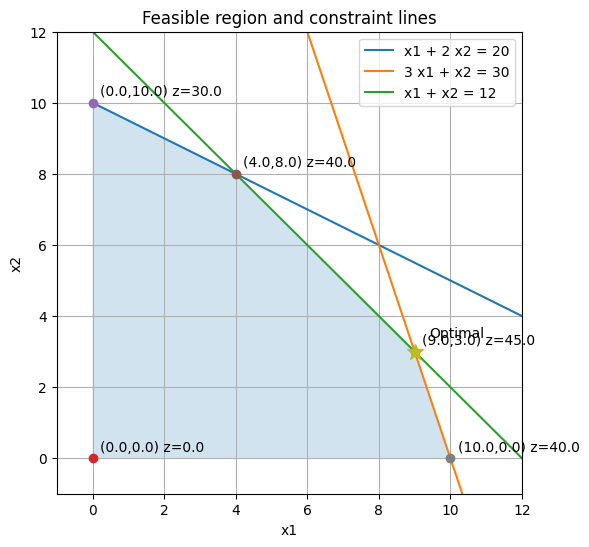

In [11]:
# HW3 CMCN Chakrabort



# Question 1
import numpy as np
import pandas as pd

# Define the LP (assumed interpretation of constraints)
# Maximize z = 4 x1 + 3 x2
# s.t.
# x1 + 2 x2 <= 20
# 3 x1 + x2 <= 30
# x1 + x2 <= 12
# x1, x2 >= 0

c = np.array([4.0, 3.0])
A = np.array([[1.0, 2.0],
              [3.0, 1.0],
              [1.0, 1.0]])
b = np.array([20.0, 30.0, 12.0])

print("Problem: maximize z = 4 x1 + 3 x2")
print("Subject to:\n x1 + 2 x2 <= 20\n 3 x1 + x2 <= 30\n x1 + x2 <= 12\n x1,x2 >= 0\n")

# 1) Graphical: compute corner points (intersections) and evaluate objective
from itertools import combinations

def line_intersection(A1, b1, A2, b2):
    M = np.vstack([A1, A2])
    if np.linalg.matrix_rank(M) < 2:
        return None
    try:
        sol = np.linalg.solve(np.array([A1, A2]), np.array([b1, b2]))
        return sol
    except Exception:
        return None

# get intersections of constraint lines pairwise and with axes
candidates = [(0.0, 0.0)]
# intersections with axes
# x1=0 -> solve A[:,1] * x2 <= b etc ; use intersections of lines with x1=0 and x2=0
for i in range(3):
    # x1 = 0 =>  a_{i2} * x2 = b_i
    if abs(A[i,1])>1e-9:
        y = b[i]/A[i,1]
        candidates.append((0.0, y))
    if abs(A[i,0])>1e-9:
        x = b[i]/A[i,0]
        candidates.append((x, 0.0))

# pairwise intersections of constraint lines
for (i,j) in combinations(range(3),2):
    M = np.array([A[i], A[j]])
    if np.linalg.matrix_rank(M) == 2:
        sol = np.linalg.solve(M, np.array([b[i], b[j]]))
        candidates.append((sol[0], sol[1]))

# filter feasible points (within tolerances)
feasible = []
for (x,y) in candidates:
    x = float(x); y = float(y)
    if x >= -1e-8 and y >= -1e-8 and np.all(A.dot([x,y]) <= b + 1e-8):
        feasible.append((round(x,6), round(y,6)))

# unique
feasible = sorted(set(feasible))
print("Feasible corner points found:")
feasible_df = pd.DataFrame(feasible, columns=['x1','x2'])
feasible_df['z'] = feasible_df['x1']*c[0] + feasible_df['x2']*c[1]
display(feasible_df)

best_idx = feasible_df['z'].idxmax()
best_point = feasible_df.loc[best_idx]
print(f"Graphical method optimum at x1={best_point.x1}, x2={best_point.x2} with z={best_point.z}\n")

# 2) Simplex tableau implementation (for <= constraints with slack variables)
def simplex_tableau(A, b, c):
    # convert to tableau for maximization
    m, n = A.shape
    # slack variables
    I = np.eye(m)
    T = np.vstack([np.hstack([A, I, b.reshape(-1,1)]),
                   np.hstack([-c.reshape(1,-1), np.zeros((1,m+1))])])
    basic = list(range(n, n+m))  # indices of basic variables (slacks)
    var_names = [f"x{i+1}" for i in range(n)] + [f"s{i+1}" for i in range(m)] + ["RHS"]
    tableaux = []
    iteration = 0
    while True:
        iteration += 1
        # store current tableau
        tableaux.append((iteration, T.copy(), basic.copy()))
        # check for optimality: last row (objective) coefficients (excluding RHS)
        cj = T[-1, :-1]
        if np.all(cj >= -1e-9):  # all nonnegative -> optimal for max
            break
        # choose entering variable (most negative reduced cost)
        entering = np.argmin(cj)
        col = T[:-1, entering]
        if np.all(col <= 1e-12):
            raise Exception("Unbounded")
        # ratio test for leaving variable
        ratios = []
        for i in range(m):
            if col[i] > 1e-12:
                ratios.append(T[i, -1] / col[i])
            else:
                ratios.append(np.inf)
        leaving_row = int(np.argmin(ratios))
        pivot = T[leaving_row, entering]
        # pivot
        T[leaving_row, :] = T[leaving_row, :] / pivot
        for i in range(m+1):
            if i != leaving_row:
                T[i, :] = T[i, :] - T[i, entering] * T[leaving_row, :]
        basic[leaving_row] = entering
        if iteration > 20:
            break
    return tableaux, T, basic, var_names

tableaux, final_tableau, basic, var_names = simplex_tableau(A, b, c)
print("Simplex tableau iterations (showing as dataframes):\n")
for it, T, basic in tableaux:
    df = pd.DataFrame(T, columns=var_names)
    # add a column indicating basic variable for each constraint row
    rows = []
    for r in range(T.shape[0]-1):
        rows.append(var_names[basic[r]])
    rows.append("Obj")
    df.insert(0, "Basic", rows)
    print(f"--- Iteration {it} ---")
    display(df)

# Extract solution from final tableau
m, n = A.shape
x = np.zeros(n + m)
for i, basic_var in enumerate(basic):
    if basic_var < n + m:
        x[basic_var] = final_tableau[i, -1]
solution_x = x[:n]
optimal_z = final_tableau[-1, -1]
print("Final solution from simplex tableau:")
print("x1 =", round(solution_x[0],6))
print("x2 =", round(solution_x[1],6))
print("Maximum z =", round(optimal_z,6))
print()

# 3) Try scipy.optimize.linprog if available (minimization form)
try:
    from scipy.optimize import linprog
    # linprog does minimization; to maximize, minimize -c
    res = linprog(-c, A_ub=A, b_ub=b, bounds=(0, None), method='highs')
    if res.success:
        print("scipy.optimize.linprog (highs) result:")
        print("x1 =", res.x[0], "x2 =", res.x[1], "max z =", -res.fun)
    else:
        print("linprog failed:", res.message)
except Exception as e:
    print("Error", e)

# Plot feasible region and objective contours
import matplotlib.pyplot as plt
x1 = np.linspace(0, 20, 400)
x2_1 = (20 - x1) / 2.0  # x1 + 2 x2 = 20
x2_2 = 30 - 3*x1       # 3 x1 + x2 = 30
x2_3 = 12 - x1         # x1 + x2 = 12

plt.figure(figsize=(6,6))
plt.plot(x1, x2_1, label='x1 + 2 x2 = 20')
plt.plot(x1, x2_2, label='3 x1 + x2 = 30')
plt.plot(x1, x2_3, label='x1 + x2 = 12')
# feasible polygon
poly = np.array(feasible_df[['x1','x2']])
# order polygon points for plotting
# we pick convex hull ordering
from scipy.spatial import ConvexHull
hull = ConvexHull(poly)
hull_pts = poly[hull.vertices]
plt.fill(hull_pts[:,0], hull_pts[:,1], alpha=0.2)
# plot feasible points and annotate z
for _, row in feasible_df.iterrows():
    plt.plot(row.x1, row.x2, 'o')
    plt.text(row.x1+0.2, row.x2+0.2, f"({row.x1},{row.x2}) z={row.z}")

# mark optimum
plt.plot(solution_x[0], solution_x[1], marker='*', markersize=12)
plt.text(solution_x[0]+0.4, solution_x[1]+0.4, "Optimal")

plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Feasible region and constraint lines")
plt.grid(True)
plt.show()


Question 2 Part I

The standard form for the maximization LP is:$$\max! \quad z = 0v_1 + 1v_2 + 0v_3$$$$\text{subject to:}$$$$\mathbf{6v_1 + 5v_2 + 3v_3 \leq 100}$$$$\mathbf{v_1 + 0.25v_2 + 0v_3 \leq 13}$$$$\mathbf{0v_1 - v_2 + v_3 \leq 30}$$$$\mathbf{v_1 + 0v_2 + v_3 = 5}$$$$\mathbf{-1000 \leq v_1 \leq 1000}$$$$\mathbf{-1000 \leq v_2 \leq 1000}$$$$\mathbf{-1000 \leq v_3 \leq 1000}$$

In [12]:
#Question 2 part 2

# The objective is to MAXIMIZE v2, so we MINIMIZE -v2.
# Objective vector c = [coeff_v1, coeff_v2, coeff_v3]
c = np.array([0, -1, 0])

# 1. Inequality Constraints (A_ub * v <= b_ub)
# Constraints: C1, C2, C3 are <= inequalities.

A_ub = np.array([
    [6, 5, 3],  # C1: 6v1 + 5v2 + 3v3 <= 100
    [1, 0.25, 0], # C2: v1 + v2/4 <= 13
    [0, -1, 1]  # C3: -v2 + v3 <= 30
])

b_ub = np.array([100, 13, 30])

# 2. Equality Constraints (A_eq * v = b_eq)
# Constraint: v1 + v3 = 5

A_eq = np.array([
    [1, 0, 1]  # C4: v1 + v3 = 5
])

b_eq = np.array([5])

# 3. Bounds
# Bounds for v1, v2, v3: [-1000, 1000]
bounds = [(-1000, 1000), (-1000, 1000), (-1000, 1000)]

# 4. Solve the Linear Program
print("--- SciPy linprog Solution (Maximize v2) ---")
result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# 5. Print Results
if result.success:
    max_v2 = -result.fun

    print(f"\nOptimization Status: {result.message}")
    print(f"\nOptimal Variable Values:")
    print(f"  v1: {result.x[0]:.4f}")
    print(f"  v2: {result.x[1]:.4f}")
    print(f"  v3: {result.x[2]:.4f}")

    print(f"\nOptimal Max(v2): {max_v2:.4f}")

    # Check if bounds were active
    v_values = result.x
    if any(v == 1000 for v in v_values) or any(v == -1000 for v in v_values):
        print("\nNote: One or more variable bounds were active in the solution.")

    # Check constraint binding
    slack = b_ub - A_ub @ v_values
    print("\nSlack values (for C1, C2, C3):")
    print(f"  C1 (6v1 + 5v2 + 3v3 <= 100): {slack[0]:.4f} (Binding if ~0)")
    print(f"  C2 (v1 + v2/4 <= 13): {slack[1]:.4f} (Binding if ~0)")
    print(f"  C3 (v3 - v2 <= 30): {slack[2]:.4f} (Binding if ~0)")

else:
    print(f"\nOptimization failed: {result.message}")

--- SciPy linprog Solution (Maximize v2) ---

Optimization Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)

Optimal Variable Values:
  v1: -105.0000
  v2: 80.0000
  v3: 110.0000

Optimal Max(v2): 80.0000

Slack values (for C1, C2, C3):
  C1 (6v1 + 5v2 + 3v3 <= 100): 0.0000 (Binding if ~0)
  C2 (v1 + v2/4 <= 13): 98.0000 (Binding if ~0)
  C3 (v3 - v2 <= 30): 0.0000 (Binding if ~0)
